<a href="https://colab.research.google.com/github/YolandaMDavis/cs109a-fall2020/blob/main/FinalProject_models_James.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

DATA_ROOT = '/content/drive/My Drive/Final-Project-for-CS109a/Milestone3/'
random_state = 109

## Data importing and preparing predictors and Response

In [3]:
new_york_crime_data_df = pd.read_csv(DATA_ROOT + 'nyc_crime_analysis_data_final.csv').drop(columns=["Unnamed: 0"])
boston_crime_data_df = pd.read_csv(DATA_ROOT + 'boston_crime_analysis_data_final.csv').drop(columns=["Unnamed: 0"])

In [4]:
boston_crime_data_df.columns

Index(['AREA', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'LATITUDE', 'LONGITUDE',
       'GEOHASH', 'COVID_PERIOD', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC',
       'MEDIAN_INCOME', 'LOCAL_PROP_VALUES', 'STREETLIGHT_DISTANCE',
       'POLICE_STATION_DISTANCE', 'HOSPITAL_DISTANCE', 'COLLEGE_UNIV_DISTANCE',
       'ELECTION', 'PRCP', 'SNOW', 'NIGHT', 'OFFENSE_TYPE', 'VIOLENT_CRIME'],
      dtype='object')

Renaming STREETLIGHT_DISTANCE to STREETLIGHT_DENSITY, to reflect what it is actually measuring

In [5]:
# creating new interaction of night and streetlight, dropping streetlight_distance
# boston_crime_data_df['NIGHT_STREETLIGHT_DENSITY'] = boston_crime_data_df['STREETLIGHT_DISTANCE']*boston_crime_data_df['NIGHT']
# boston_crime_data_df.drop(columns=['STREETLIGHT_DISTANCE'], inplace=True)
# new_york_crime_data_df['NIGHT_STREETLIGHT_DENSITY'] = new_york_crime_data_df['STREETLIGHT_DISTANCE']*new_york_crime_data_df['NIGHT']
# new_york_crime_data_df.drop(columns=['STREETLIGHT_DISTANCE'], inplace=True)

boston_crime_data_df.rename(columns = {'STREETLIGHT_DISTANCE':'STREETLIGHT_DENSITY'}, inplace = True) 
new_york_crime_data_df.rename(columns = {'STREETLIGHT_DISTANCE':'STREETLIGHT_DENSITY'}, inplace = True) 

For Boston predictors, dropping outcomes, and geohash. For Generalized/Full, dropping also Lat/Long and Area. Using random_state to create same split for each team member

In [6]:
boston_X = boston_crime_data_df.drop(columns=['OFFENSE_TYPE', 'VIOLENT_CRIME', 'GEOHASH'])
boston_y = boston_crime_data_df['VIOLENT_CRIME']
boston_multi_y = boston_crime_data_df['OFFENSE_TYPE']

# Create Train/Test splits for Boston
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(boston_X, boston_y, train_size=.8, random_state = random_state)

# Train/Test splits for Multi-class
boston_X_train, boston_X_test, boston_multi_y_train, boston_multi_y_test = train_test_split(boston_X, boston_multi_y, train_size=.8, random_state = random_state)

# Combine Data Sets and split for Generalized Analysis
combined_crime_data_df = pd.concat([boston_crime_data_df, new_york_crime_data_df])
combined_crime_X = combined_crime_data_df.drop(columns=['OFFENSE_TYPE', 'VIOLENT_CRIME', 'GEOHASH', 'LATITUDE', 'LONGITUDE', 'AREA'])
combined_crime_y = combined_crime_data_df['VIOLENT_CRIME']
combined_crime_multi_y = combined_crime_data_df['OFFENSE_TYPE']

# Train/Test splits for full dataset
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(combined_crime_X, combined_crime_y, train_size=.8, random_state = random_state)
# Train/Test splits for full dataset, multi-class
full_X_train, full_X_test, full_multi_y_train, full_multi_y_test = train_test_split(combined_crime_X, combined_crime_multi_y, train_size=.8, random_state = random_state)

Take a look at the data, Make sure the columns look correct

In [7]:
boston_X_train.head()

,AREA,YEAR,MONTH,DAY_OF_WEEK,HOUR,LATITUDE,LONGITUDE,COVID_PERIOD,WHITE,BLACK,ASIAN,HISPANIC,MEDIAN_INCOME,LOCAL_PROP_VALUES,STREETLIGHT_DENSITY,POLICE_STATION_DISTANCE,HOSPITAL_DISTANCE,COLLEGE_UNIV_DISTANCE,ELECTION,PRCP,SNOW,NIGHT
2742,E13,2019,10,Thursday,2,42.352341,-71.062969,0,0.550542,0.111894,0.061581,0.237167,84445.9000,9.305048e+06,32.0,652.050031,251.777302,109.854794,0.0600,0.02,0.0,1.0
26647,A1,2020,1,Monday,16,42.366435,-71.061354,0,0.727176,0.030437,0.140236,0.080069,89833.4675,7.404941e+07,12.0,520.414789,197.460227,543.641269,0.2775,0.01,0.0,0.0
198235,A1,2016,7,Monday,20,42.361110,-71.067414,0,0.727176,0.030437,0.140236,0.080069,89833.4675,3.901778e+07,49.0,590.590051,233.028485,278.147512,0.2775,0.01,0.0,1.0
51448,B3,2020,5,Friday,23,42.277963,-71.092463,1,0.067967,0.730087,0.017705,0.153209,48196.9000,4.666762e+06,18.0,748.546146,2203.859460,2248.707217,0.0400,0.79,0.0,1.0
68679,B3,2020,7,Tuesday,16,42.280727,-71.077136,1,0.067967,0.730087,0.017705,0.153209,48196.9000,7.851202e+06,0.0,1276.128447,1010.720978,1053.834615,0.0400,0.62,0.0,0.0


In [8]:
full_X_train.head()

,YEAR,MONTH,DAY_OF_WEEK,HOUR,COVID_PERIOD,WHITE,BLACK,ASIAN,HISPANIC,MEDIAN_INCOME,LOCAL_PROP_VALUES,STREETLIGHT_DENSITY,POLICE_STATION_DISTANCE,HOSPITAL_DISTANCE,COLLEGE_UNIV_DISTANCE,ELECTION,PRCP,SNOW,NIGHT
242278,2020,2,Thursday,19,0,0.090989,0.290291,0.038122,0.561581,38740.127767,4.455077e+05,0.0,703.963608,355.539466,2071.643885,0.11,0.40,0.0,0.0
229277,2016,11,Thursday,19,0,0.215249,0.453834,0.094452,0.180933,49662.360000,1.050727e+06,6.0,1509.431329,2638.058680,1828.886949,0.20,0.00,0.0,0.0
240914,2017,1,Friday,13,0,0.550542,0.111894,0.061581,0.237167,84445.900000,2.479460e+06,30.0,838.491817,568.757936,1583.991917,0.06,0.06,1.1,0.0
377031,2018,6,Friday,20,0,0.731972,0.058357,0.071636,0.118406,103243.160000,7.567873e+05,60.0,764.090021,458.477056,716.029361,0.28,0.00,0.0,1.0
80815,2020,8,Sunday,21,1,0.325667,0.025571,0.038067,0.574151,52935.360000,1.173795e+06,8.0,915.779139,1566.465488,1731.148782,0.31,0.00,0.0,1.0


## One hot encoding for categorical. 
### Different set for Boston and Generalized (full), since Area and Lat/Long were dropped from the larger dataset

In [9]:
# prep data -- one hot encoding for categoricals, different for boston and full
categoricals_boston = ['AREA', 'DAY_OF_WEEK']
categoricals_full = ['DAY_OF_WEEK']

boston_X_train, boston_X_test = pd.get_dummies(boston_X_train, columns=categoricals_boston), pd.get_dummies(boston_X_test, columns=categoricals_boston)
full_X_train, full_X_test = pd.get_dummies(full_X_train, columns=categoricals_full), pd.get_dummies(full_X_test, columns=categoricals_full)


## Creating scaled data sets (for kNN and Neural Network)

In [10]:

boston_scaler = MinMaxScaler().fit(boston_X_train)
boston_X_train_scaled = boston_scaler.transform(boston_X_train)
boston_X_test_scaled = boston_scaler.transform(boston_X_test)

full_scaler = MinMaxScaler().fit(full_X_train)
full_X_train_scaled = full_scaler.transform(full_X_train)
full_X_test_scaled = full_scaler.transform(full_X_test)

## Factorizing multiclass Y for models

In [11]:
boston_multi_y_train, categories = pd.factorize(boston_multi_y_train, sort=True)
boston_multi_y_test, categories = pd.factorize(boston_multi_y_test, sort=True)

## Smaller datasets for use in developing NN models

In [23]:
# reduce the number of rows by 10 for NN to work a bit faster, for tuning...
# index = np.random.choice(boston_X_train.shape[0], int(boston_X_train.shape[0]/10), replace=False)
# boston_X_train_sample = boston_X_train[index,:]
# boston_y_train_sample = boston_y_train.iloc[index]

In [47]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(boston_y_train),
#                                                  boston_y_train)
# class_weights = dict(enumerate(class_weights))      

##  Neural Network Definition and Summary - Violent Crime

In [ ]:
nn_boston_VC = tf.keras.models.Sequential(name='Boston_Violent')

regularizer = tf.keras.regularizers.l2(0.01)

nn_boston_VC.add(tf.keras.layers.Dense(30, activation="tanh", input_shape=(boston_X_train.shape[1],), name="hidden1"))
nn_boston_VC.add(tf.keras.layers.Dense(1000, activation="relu", name="hidden2"))
nn_boston_VC.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

nn_boston_VC.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
nn_boston_VC.summary()

In [ ]:
%%time
# Naive model classification = 0.918

history = nn_boston_VC.fit(boston_X_train_scaled, boston_y_train, validation_split=0.2, epochs=500, batch_size=256, callbacks=[callback], verbose=2)

## Neural Network Definition and Summary - Offense Type

In [107]:
# define nn
nn_boston = tf.keras.models.Sequential(name='Boston')

regularizer = tf.keras.regularizers.l2(0.01)

nn_boston.add(tf.keras.layers.Dense(30, activation="tanh", input_shape=(boston_X_train.shape[1],), name="hidden1"))
nn_boston.add(tf.keras.layers.Dense(1000, activation="relu", name="hidden2"))
nn_boston.add(tf.keras.layers.Dropout(0.3))
nn_boston.add(tf.keras.layers.Dense(1000, activation="relu", name="hidden3"))
nn_boston.add(tf.keras.layers.Dropout(0.4))
nn_boston.add(tf.keras.layers.Dense(19, activation="softmax"))

In [108]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

nn_boston.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [109]:
nn_boston.summary()

Model: "Boston"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 30)                1200      
_________________________________________________________________
hidden2 (Dense)              (None, 1000)              31000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
hidden3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 19)                19019     
Total params: 1,052,219
Trainable params: 1,052,219
Non-trainable params: 0
__________________________________________________

## Neural Network for Offense Type in Boston

In [110]:
%%time
# Naive model classification = 0.45/0.451

history = nn_boston.fit(boston_X_train_scaled, boston_multi_y_train, validation_split=0.2, epochs=500, batch_size=256, callbacks=[callback], verbose=2)

Epoch 1/500
1230/1230 - 3s - loss: 1.8376 - accuracy: 0.4486 - val_loss: 1.7928 - val_accuracy: 0.4515
Epoch 2/500
1230/1230 - 3s - loss: 1.8014 - accuracy: 0.4500 - val_loss: 1.7874 - val_accuracy: 0.4523
Epoch 3/500
1230/1230 - 3s - loss: 1.7941 - accuracy: 0.4503 - val_loss: 1.7846 - val_accuracy: 0.4515
Epoch 4/500
1230/1230 - 3s - loss: 1.7895 - accuracy: 0.4508 - val_loss: 1.7801 - val_accuracy: 0.4523
Epoch 5/500
1230/1230 - 3s - loss: 1.7859 - accuracy: 0.4510 - val_loss: 1.7786 - val_accuracy: 0.4525
Epoch 6/500
1230/1230 - 3s - loss: 1.7821 - accuracy: 0.4513 - val_loss: 1.7747 - val_accuracy: 0.4524
Epoch 7/500
1230/1230 - 3s - loss: 1.7799 - accuracy: 0.4511 - val_loss: 1.7735 - val_accuracy: 0.4528
Epoch 8/500
1230/1230 - 3s - loss: 1.7774 - accuracy: 0.4518 - val_loss: 1.7718 - val_accuracy: 0.4532
Epoch 9/500
1230/1230 - 3s - loss: 1.7749 - accuracy: 0.4519 - val_loss: 1.7692 - val_accuracy: 0.4529
Epoch 10/500
1230/1230 - 3s - loss: 1.7727 - accuracy: 0.4523 - val_loss:

Text(0.5, 0.98, 'NN Training')

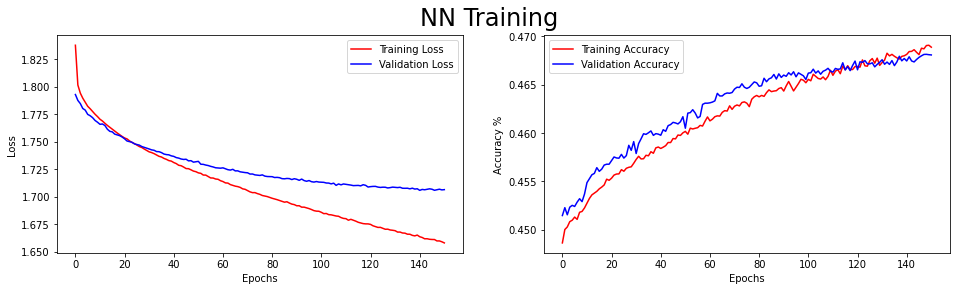

In [111]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('NN Training', fontsize = 24)

In [112]:
predict_proba_train = nn_boston.predict(boston_X_train_scaled)
y_pred_train_nn_boston = np.apply_along_axis(np.argmax, 1, predict_proba_train)

predict_proba_test = nn_boston.predict(boston_X_test_scaled)
y_pred_test_nn_boston = np.apply_along_axis(np.argmax, 1, predict_proba_test)

nn_train_score_boston = accuracy_score(boston_multi_y_train, y_pred_train_nn_boston)
nn_test_score_boston = accuracy_score(boston_multi_y_test, y_pred_test_nn_boston)

print(f"""Neural Network: 
train accuracy is {nn_train_score_boston:.4f} and
test accuracy is {nn_test_score_boston:.4f}""")

Neural Network: 
train accuracy is 0.4732 and
test accuracy is 0.4676


## Binarizing Y to get AUC score for NN

In [18]:

# binarizing to get AUC score
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
y_test_bin = label_binarize(boston_multi_y_test, classes=labels)
y_pred_test_bin = label_binarize(y_pred_test_nn_boston, classes=labels)

In [19]:
roc_auc_score(y_test_bin, y_pred_test_bin,average='macro',multi_class='ovo')

0.5171396020787601

# Random Forest Classifier

In [13]:
%%time
#BOSTON Random Forest
# Naive model = 0.918


n_trees = 210
tree_depth = 20

rf_boston = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=random_state)
rf_boston.fit(boston_X_train, boston_y_train)

y_pred_train_rf_boston = rf_boston.predict(boston_X_train)
y_pred_test_rf_boston = rf_boston.predict(boston_X_test)

rf_train_score_boston = accuracy_score(boston_y_train, y_pred_train_rf_boston)
rf_test_score_boston = accuracy_score(boston_y_test, y_pred_test_rf_boston)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_boston:.4f} and
test accuracy is {rf_test_score_boston:.4f}""")

Random Forest with 20 max_depth and 210 trees, 
train accuracy is 0.9335 and
test accuracy is 0.9274
CPU times: user 2min 44s, sys: 358 ms, total: 2min 44s
Wall time: 2min 44s


In [13]:
# helper code to plot feature importances for tree-based models
def plot_importances(model, X, num):
    model_importances = model.feature_importances_
    model_importances = pd.Series(model_importances).fillna(0)
    order = np.flip(np.argsort(model_importances))[0:num]
    plt.barh(range(num),model_importances[order],tick_label=X.columns[order]);
    plt.title(f"Relative Variable Importances for {type(model).__name__}")

RF with n_trees = 200, max_depth = 10. Test accuracy = 0.9227
n_trees = 210, max_depth = 20. Test accuracy = 0.9273

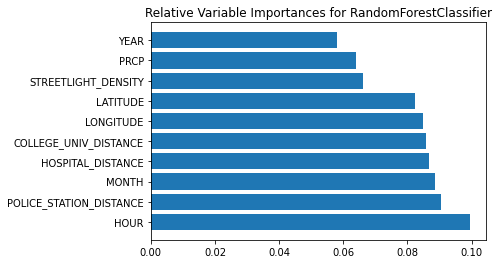

In [15]:
plot_importances(rf_boston, boston_X_train, 10)

In [17]:
def plot_permute_importance(importances,X,y):
  plt.figure(figsize=(10,10))

  tree_importance_sorted_idx = np.argsort(importances.importances_mean)
  tree_indices = np.arange(0, len(importances.importances_mean)) +0.5

  plt.barh(tree_indices, importances.importances_mean[tree_importance_sorted_idx], height=0.7, color='#EFAEA4')
  plt.yticks(tree_indices, labels=X.columns[tree_importance_sorted_idx], fontsize=12)
  plt.ylim((0, len(importances.importances_mean)))
  plt.xlabel("Permutation Feature Importance", fontsize=16)
  maxlim = max(importances.importances_mean)
  plt.xlim(0,maxlim+0.015)
  plt.title("Permutation Importance", fontsize=18)
  plt.show()

In [ ]:
# from sklearn.inspection import permutation_importance

# rf_importances = permutation_importance(rf_boston, boston_X_train, boston_y_train, random_state=random_state)

# plot_permute_importance(rf_importances, boston_X_train, boston_y_train)

In [11]:
%%time
#Full Random Forest
n_trees = 210
tree_depth = 20

rf_full = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51)
rf_full.fit(full_X_train, full_y_train)

y_pred_train_rf_full = rf_full.predict(full_X_train)
y_pred_test_rf_full = rf_full.predict(full_X_test)

rf_train_score_full = accuracy_score(full_y_train, y_pred_train_rf_full)
rf_test_score_full = accuracy_score(full_y_test, y_pred_test_rf_full)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_train_score_full:.3f} and
test accuracy is {rf_test_score_full:.3f}""")

Random Forest with 20 max_depth and 210 trees, 
train accuracy is 0.901 and
test accuracy is 0.894
CPU times: user 7min 55s, sys: 976 ms, total: 7min 56s
Wall time: 7min 57s


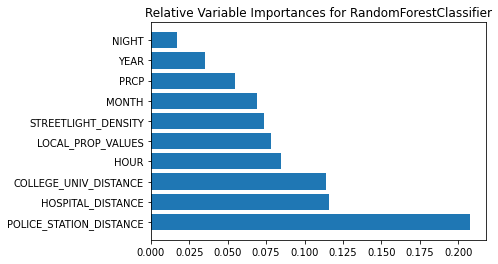

In [19]:
plot_importances(rf_full, full_X_train, 10)

In [18]:
# BOSTON multifactor RF
n_trees = 300
tree_depth = 20

rf_boston = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51)
rf_boston.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_boston_multi_train = rf_boston.predict(boston_X_train)
y_pred_rf_boston_multi_test = rf_boston.predict(boston_X_test)

rf_boston_multi_train = accuracy_score(boston_multi_y_train, y_pred_rf_boston_multi_train)
rf_boston_multi_test = accuracy_score(boston_multi_y_test, y_pred_rf_boston_multi_test)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_boston_multi_train:.4f} and
test accuracy is {rf_boston_multi_test:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.6447 and
test accuracy is 0.4902


This train accuracy is quite good, but the test accuracy isn't so good. These seem possibly to be overfitting. With just 10 depth, we're not getting very good numbers. So we could set a min_samples_leaf to "prune back" the trees.

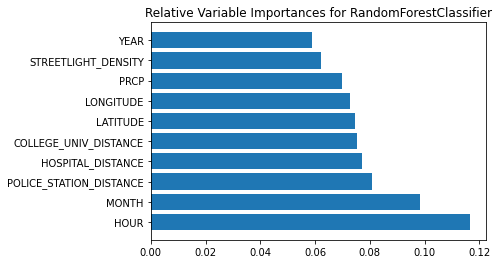

In [19]:
plot_importances(rf_boston, boston_X_train, 10)

In [20]:
# Boston multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 50

rf_multi_pruned = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_pruned.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_pruned_train = rf_multi_pruned.predict(boston_X_train)
y_pred_rf_multi_pruned_test = rf_multi_pruned.predict(boston_X_test)

rf_multi_pruned_train = accuracy_score(boston_multi_y_train, y_pred_rf_multi_pruned_train)
rf_multi_pruned_test = accuracy_score(boston_multi_y_test, y_pred_rf_multi_pruned_test)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_pruned_train:.4f} and
test accuracy is {rf_multi_pruned_test:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.4818 and
test accuracy is 0.4777


This model doesn't really overfit, but we're not getting as good test accuracy as the deep model without min_samples_leaf set. Maybe a slightly lower setting for min_samples_leaf would work. (We could do all of this via cv and grid search, but each tree takes so long to run that this seems a better course).

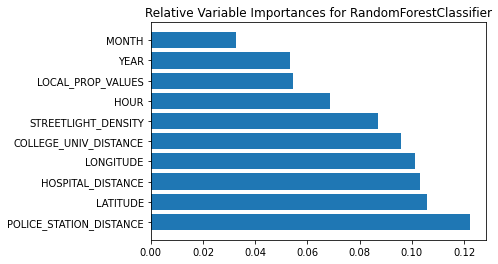

In [21]:
plot_importances(rf_multi_pruned, boston_X_train, 10)

In [22]:
# Boston multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 25

rf_multi_pruned2 = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_pruned2.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_pruned_train2 = rf_multi_pruned2.predict(boston_X_train)
y_pred_rf_multi_pruned_test2 = rf_multi_pruned2.predict(boston_X_test)

rf_multi_pruned_train2 = accuracy_score(boston_multi_y_train, y_pred_rf_multi_pruned_train2)
rf_multi_pruned_test2 = accuracy_score(boston_multi_y_test, y_pred_rf_multi_pruned_test2)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_pruned_train2:.4f} and
test accuracy is {rf_multi_pruned_test2:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.4895 and
test accuracy is 0.4817


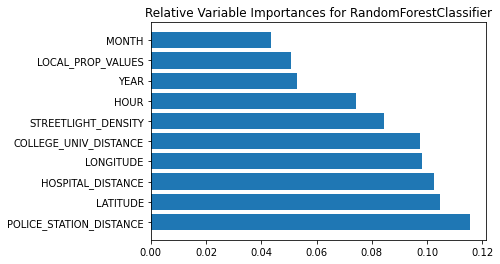

In [23]:
plot_importances(rf_multi_pruned2, boston_X_train, 10)

In [24]:
# Boston multifactor with pruning, 3rd time a charm?
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_pruned3 = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_pruned3.fit(boston_X_train, boston_multi_y_train)

y_pred_rf_multi_pruned_train3 = rf_multi_pruned3.predict(boston_X_train)
y_pred_rf_multi_pruned_test3 = rf_multi_pruned3.predict(boston_X_test)

rf_multi_pruned_train3 = accuracy_score(boston_multi_y_train, y_pred_rf_multi_pruned_train3)
rf_multi_pruned_test3 = accuracy_score(boston_multi_y_test, y_pred_rf_multi_pruned_test3)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees, 
train accuracy is {rf_multi_pruned_train3:.4f} and
test accuracy is {rf_multi_pruned_test3:.4f}""")

Random Forest with 20 max_depth and 300 trees, 
train accuracy is 0.5054 and
test accuracy is 0.4858


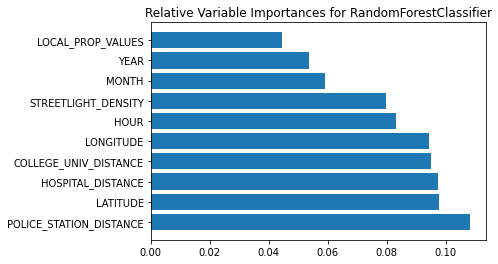

In [25]:
plot_importances(rf_multi_pruned3, boston_X_train, 10)

In [15]:
%%time
# Generalized multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 10

rf_multi_full_pruned = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_full_pruned.fit(full_X_train, full_multi_y_train)

y_pred_rf_multi_full_pruned_train = rf_multi_full_pruned.predict(full_X_train)
y_pred_rf_multi_full_pruned_test = rf_multi_full_pruned.predict(full_X_test)

rf_multi_full_pruned_train = accuracy_score(full_multi_y_train, y_pred_rf_multi_full_pruned_train)
rf_multi_full_pruned_test = accuracy_score(full_multi_y_test, y_pred_rf_multi_full_pruned_test)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees and {min_samples} minimum samples per leaf, 
train accuracy is {rf_multi_full_pruned_train:.4f} and
test accuracy is {rf_multi_full_pruned_test:.4f}""")

Random Forest with 20 max_depth and 300 trees and 10 minimum samples per leaf, 
train accuracy is 0.4919 and
test accuracy is 0.4551
CPU times: user 10min 40s, sys: 1.95 s, total: 10min 42s
Wall time: 10min 43s


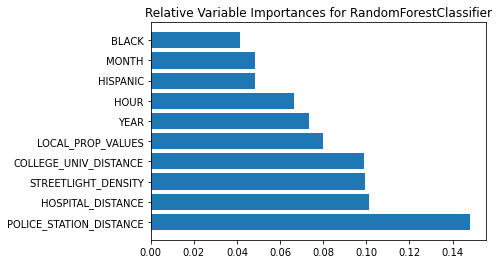

In [18]:
plot_importances(rf_multi_full_pruned, full_X_train, 10)

In [20]:
%%time
# Generalized multifactor with pruning
n_trees = 300
tree_depth = 20
min_samples = 20

rf_multi_full_pruned2 = RandomForestClassifier(max_depth=tree_depth, n_estimators=n_trees, max_features='sqrt', random_state=51, min_samples_leaf=min_samples)
rf_multi_full_pruned2.fit(full_X_train, full_multi_y_train)

y_pred_rf_multi_full_pruned_train2 = rf_multi_full_pruned2.predict(full_X_train)
y_pred_rf_multi_full_pruned_test2 = rf_multi_full_pruned2.predict(full_X_test)

rf_multi_full_pruned_train2 = accuracy_score(full_multi_y_train, y_pred_rf_multi_full_pruned_train2)
rf_multi_full_pruned_test2 = accuracy_score(full_multi_y_test, y_pred_rf_multi_full_pruned_test2)

print(f"""Random Forest with {tree_depth} max_depth and {n_trees} trees and {min_samples} minimum samples per leaf, 
train accuracy is {rf_multi_full_pruned_train2:.4f} and
test accuracy is {rf_multi_full_pruned_test2:.4f}""")

Random Forest with 20 max_depth and 300 trees and 20 minimum samples per leaf, 
train accuracy is 0.4738 and
test accuracy is 0.4520
CPU times: user 8min 55s, sys: 1.95 s, total: 8min 57s
Wall time: 8min 58s


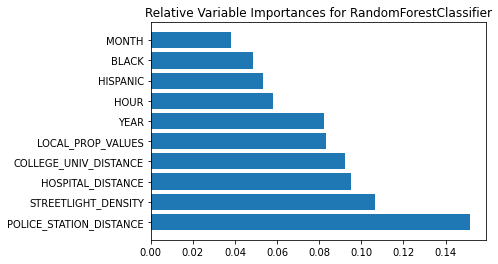

In [21]:
plot_importances(rf_multi_full_pruned2, full_X_train, 10)

# K Nearest Neighbors
Yikes, this was time-instensive to run.

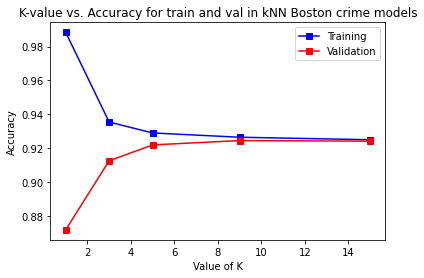

Best value of K is 9
Train accuracy of best (k=9) model: 0.9272
Test accuracy of best (k=9) model: 0.9252


In [10]:
training_error, validation_error = [],[]

ks = [1,3,5,9,15]

for k in ks:
    
    knn = KNeighborsClassifier(n_neighbors=k)

    knn_cv = cross_validate(knn,boston_X_train_scaled,boston_y_train, scoring="accuracy", return_train_score=True, cv=3)
    
    acc_train = knn_cv['train_score'].mean()
    acc_val = knn_cv['test_score'].mean()
        
    training_error.append(acc_train)
    validation_error.append(acc_val)
    
plt.plot(ks, training_error, 's-', color="blue", label="Training")
plt.plot(ks, validation_error, 's-', color="red", label="Validation")
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.title("K-value vs. Accuracy for train and val in kNN Boston crime models")
plt.legend()
plt.show()

best_acc  = max(validation_error)
best_k = ks[validation_error.index(best_acc)]

print(f'Best value of K is {best_k}')

knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(boston_X_train_scaled,boston_y_train)

knn_model_train_accuracy = knn_model.score(boston_X_train_scaled, boston_y_train)
knn_model_test_accuracy = knn_model.score(boston_X_test_scaled, boston_y_test)

print(f'Train accuracy of best (k={best_k}) model: {knn_model_train_accuracy:.4f}')
print(f'Test accuracy of best (k={best_k}) model: {knn_model_test_accuracy:.4f}')

In [26]:
# knn with same best K, coding so don't have to redo analysis
best_k = 9

# knn on full data for violent/non-violent
knn_model_full = KNeighborsClassifier(n_neighbors=best_k).fit(full_X_train_scaled, full_y_train)

knn_model_full_train_accuracy = knn_model_full.score(full_X_train_scaled, full_y_train)
knn_model_full_test_accuracy = knn_model_full.score(full_X_test_scaled, full_y_test)

print(f'Train accuracy of best (k={best_k}) model: {knn_model_full_train_accuracy:.4f}')
print(f'Test accuracy of best (k={best_k}) model: {knn_model_full_test_accuracy:.4f}')

Train accuracy of best (k=9) model: 0.8894
Test accuracy of best (k=9) model: 0.8828


kNN with the same best k from Boston only did not do any better than naive model on the full dataset. Since even this one run took quite a long time, and kNN is not very interpretable, it makes sense that this is not a good model to pursue